# Python version

In [1]:
from platform import python_version

print(python_version())

3.10.11


# pip install OpenOA

After the installation, please restart the notebook.

In [5]:
%pip install OpenOA

Note: you may need to restart the kernel to use updated packages.


# About this environment

This environment contains python, jupyter, and VSCode and many dependencies that may be required for Data Science related projects, including pandas, numpy, scipy, scikit-learn, plotly, torch, transformers, pytorch-lightning, matplotlib, seaborn, tqdm, and nvcc among others.

To install additional packages simply run %pip install <package> in a cell

# Imports

In [17]:
import os
import copy
from datetime import datetime

import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np
from IPython.display import clear_output

from openoa.utils import plot
from openoa.utils import qa
from openoa.analysis import TurbineLongTermGrossEnergy

import project_kelmarsh as pk
from pathlib import Path
import pandas as pd

KELMARSH_DATA = Path("kelmarsh-wind-farm-data-doi-10.5281-zenodo.5841833").resolve()
KELMARSH_DATA

PosixPath('/home/jovyan/work/kelmarsh-wind-farm-data-doi-10.5281-zenodo.5841833')

# Kelmarsh data to PlantData object

The Kelmarsh data can be found in the "kelmarsh-wind-farm-data-doi-10.5281-zenodo.5841833" folder.

The `pk.prepare` helper function will unzip the SCADA data for the specified year and load them to a PlantData object.

**NOTE**: The Renku environment has very limited resources, especially memory. It is advised to only use data from one year by setting e.g. year=2016.

In [9]:
# Set extract=False after the first run to prevent unzipping everything again. This will save a lot of time.
project = pk.prepare(root_folder=KELMARSH_DATA, asset="Kelmarsh", output_folder="data", year=2016, extract=True, return_value="plantdata")
project.analysis_type.append("TurbineLongTermGrossEnergy")
project.validate()

In [15]:
project.scada.tail()

,,WMET_HorWdSpd,WMET_HorWdDir,Nacelle position (°),WTUR_W,WMET_EnvTmp,WROT_BlPthAngVal,WTUR_SupWh
time,asset_id,,,,,,,
2016-12-31 23:10:00,Kelmarsh 2,6.720456,217.715317,224.145996,603.875122,7.6950,0.0,100.645854
2016-12-31 23:20:00,Kelmarsh 2,6.239416,216.229752,224.145996,539.811157,7.6650,0.0,89.968526
2016-12-31 23:30:00,Kelmarsh 2,6.340375,218.807007,224.145996,566.706604,7.4575,0.0,94.451101
2016-12-31 23:40:00,Kelmarsh 2,7.778421,210.376678,212.993011,932.670410,7.3750,0.0,155.445068
2016-12-31 23:50:00,Kelmarsh 2,6.908651,212.279587,209.878006,710.842834,7.3650,0.0,118.473806


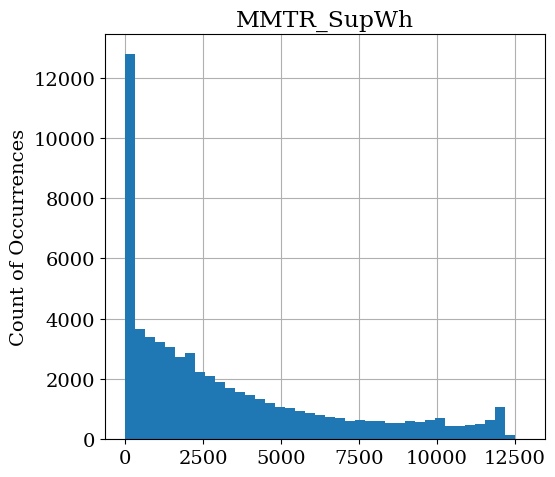

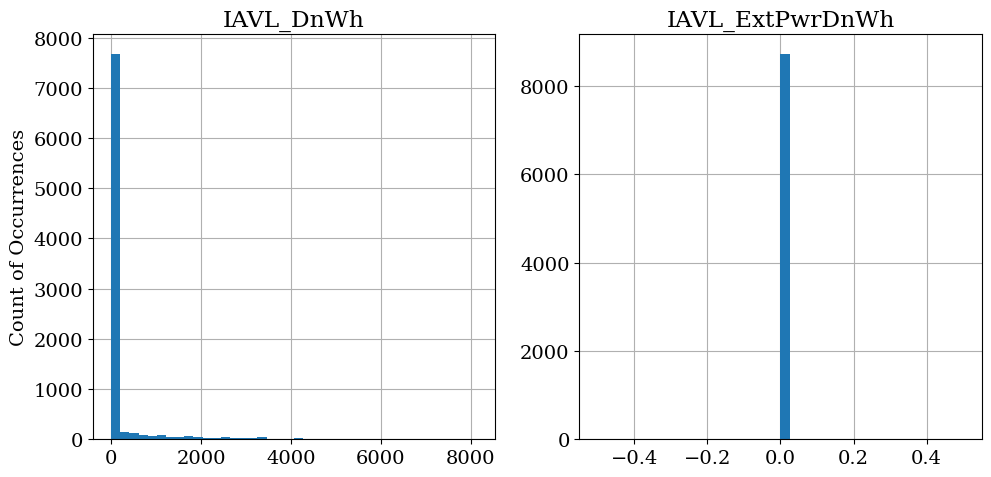

In [10]:
plot.column_histograms(project.meter.resample("1h").sum(numeric_only=True), columns=["MMTR_SupWh"])
plot.column_histograms(project.curtail.resample("1h").sum(numeric_only=True), columns=["IAVL_DnWh", "IAVL_ExtPwrDnWh"])

In [11]:
project.meter.tail()

,MMTR_SupWh
time,
2022-12-31 23:10:00,1344.0
2022-12-31 23:20:00,1676.0
2022-12-31 23:30:00,1529.0
2022-12-31 23:40:00,1598.0
2022-12-31 23:50:00,2073.0


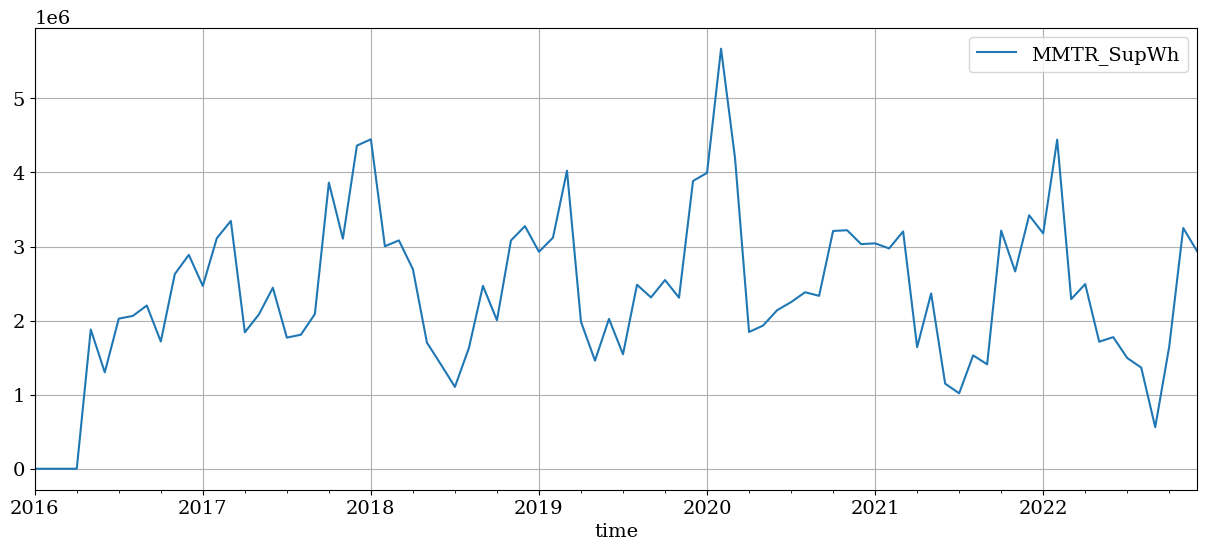

In [12]:
project.meter.resample("1ME").sum(numeric_only=True).plot();

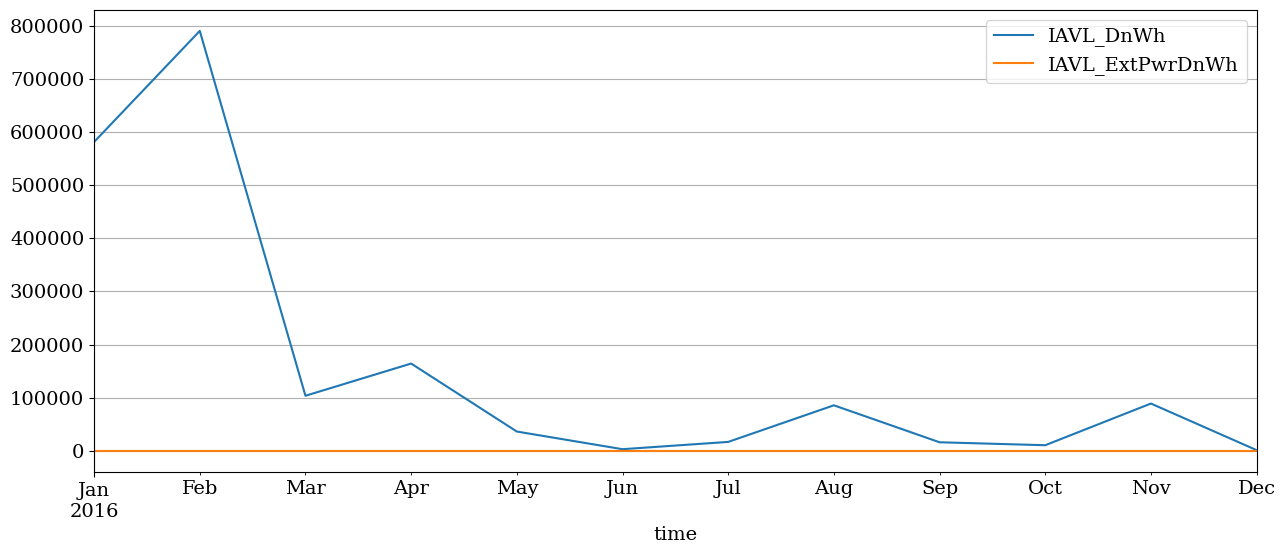

In [13]:
project.curtail.resample("1ME").sum(numeric_only=True).plot();

# Kelmarsh data to pandas DataFrames

The `pk.prepare` helper function will unzip the SCADA data for the specified year and load them to pandas DataFrames.

**NOTE**: The Renku environment has very limited resources, especially memory. It is advised to only use data from one year by setting e.g. year=2016.

In [21]:
# Set extract=False after the first run to prevent unzipping everything again. This will save a lot of time.
scada_df, meter_df, curtail_df, asset_df, _ = pk.prepare(root_folder=KELMARSH_DATA, asset="Kelmarsh", output_folder="data", year=2016, extract=False, return_value="dataframes")

In [17]:
scada_df_tz = qa.convert_datetime_column(
    df=scada_df,
    time_col="Timestamp",
    local_tz="Europe/Paris",
    tz_aware=True # Indicate that we can use encoded data to convert between timezones
)
scada_df_tz.head()

,Timestamp,Wind speed (m/s),Wind direction (°),Nacelle position (°),Power (kW),Nacelle ambient temperature (°C),Blade angle (pitch position) A (°),Turbine,Timestamp_localized,Timestamp_utc,utc_offset,is_dst
Timestamp_utc,,,,,,,,,,,,
2016-01-03 00:00:00+00:00,2016-01-03 01:00:00+01:00,NaN,NaN,NaN,NaN,NaN,NaN,Kelmarsh 3,2016-01-03 01:00:00+01:00,2016-01-03 00:00:00+00:00,0 days 01:00:00,False
2016-01-03 00:10:00+00:00,2016-01-03 01:10:00+01:00,NaN,NaN,NaN,NaN,NaN,NaN,Kelmarsh 3,2016-01-03 01:10:00+01:00,2016-01-03 00:10:00+00:00,0 days 01:00:00,False
2016-01-03 00:20:00+00:00,2016-01-03 01:20:00+01:00,NaN,NaN,NaN,NaN,NaN,NaN,Kelmarsh 3,2016-01-03 01:20:00+01:00,2016-01-03 00:20:00+00:00,0 days 01:00:00,False
2016-01-03 00:30:00+00:00,2016-01-03 01:30:00+01:00,NaN,NaN,NaN,NaN,NaN,NaN,Kelmarsh 3,2016-01-03 01:30:00+01:00,2016-01-03 00:30:00+00:00,0 days 01:00:00,False
2016-01-03 00:40:00+00:00,2016-01-03 01:40:00+01:00,NaN,NaN,NaN,NaN,NaN,NaN,Kelmarsh 3,2016-01-03 01:40:00+01:00,2016-01-03 00:40:00+00:00,0 days 01:00:00,False


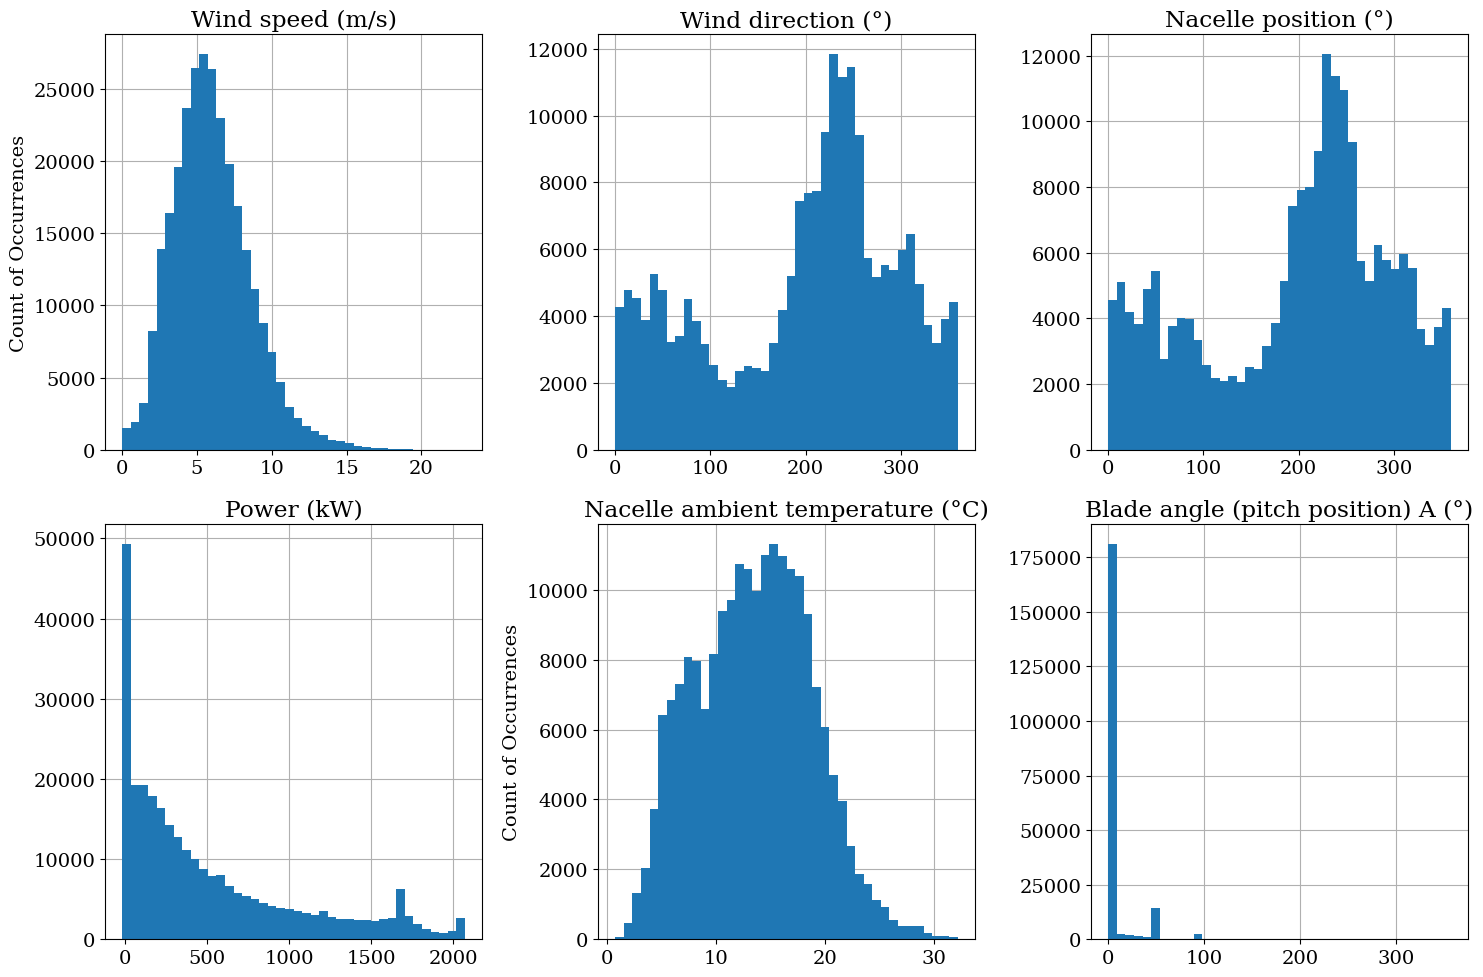

In [18]:
plot.column_histograms(scada_df_tz)

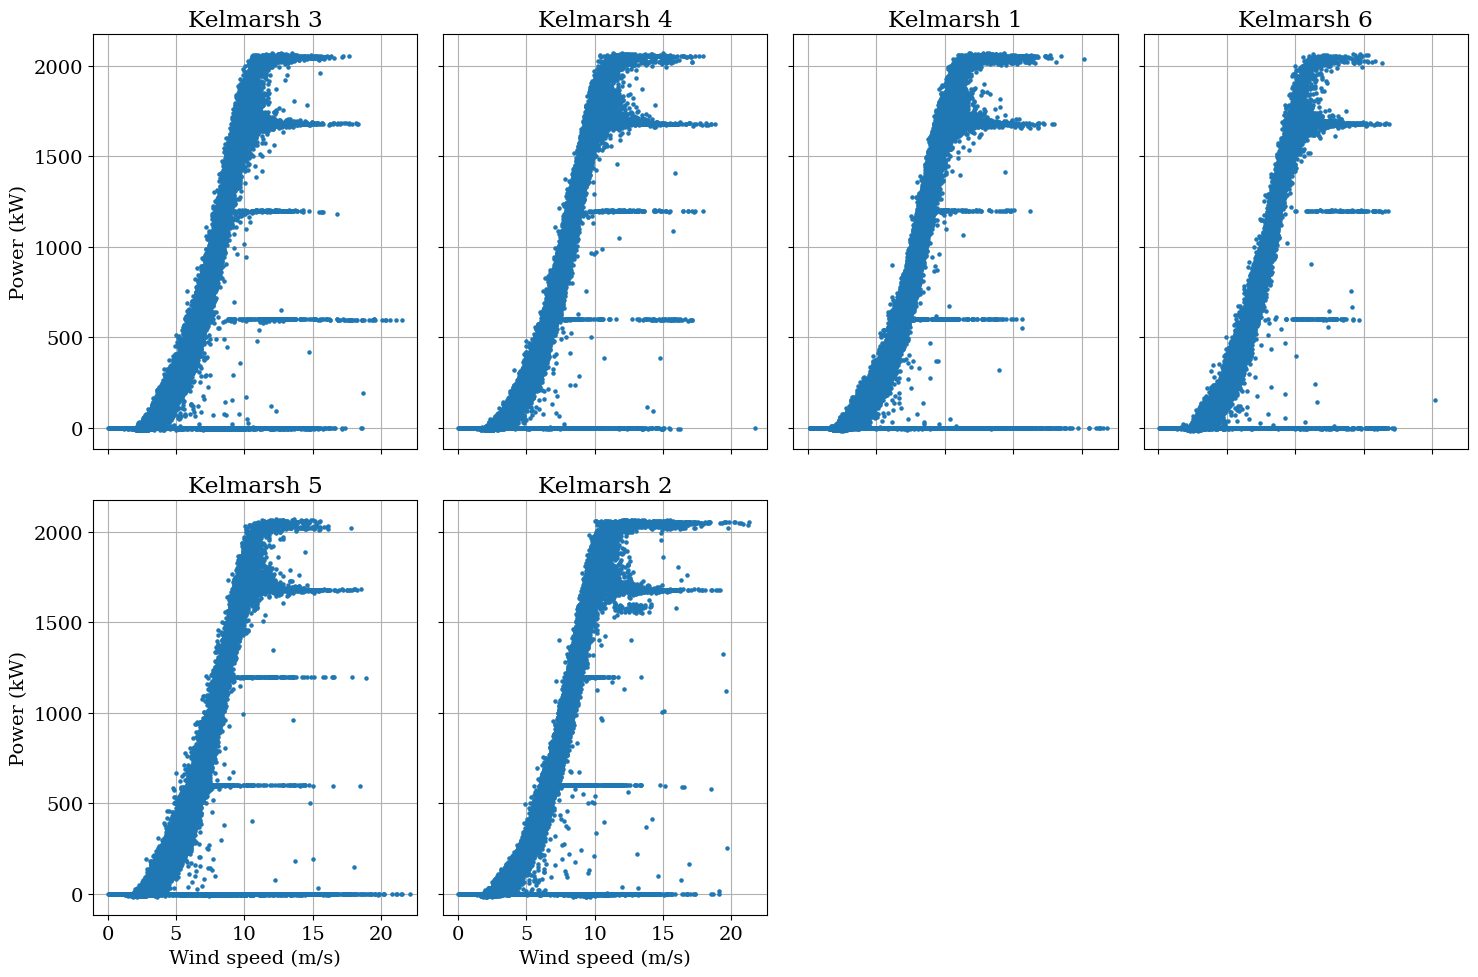

In [19]:
plot.plot_by_id(
    df=scada_df_tz,
    id_col="Turbine",
    x_axis="Wind speed (m/s)",
    y_axis="Power (kW)",
)

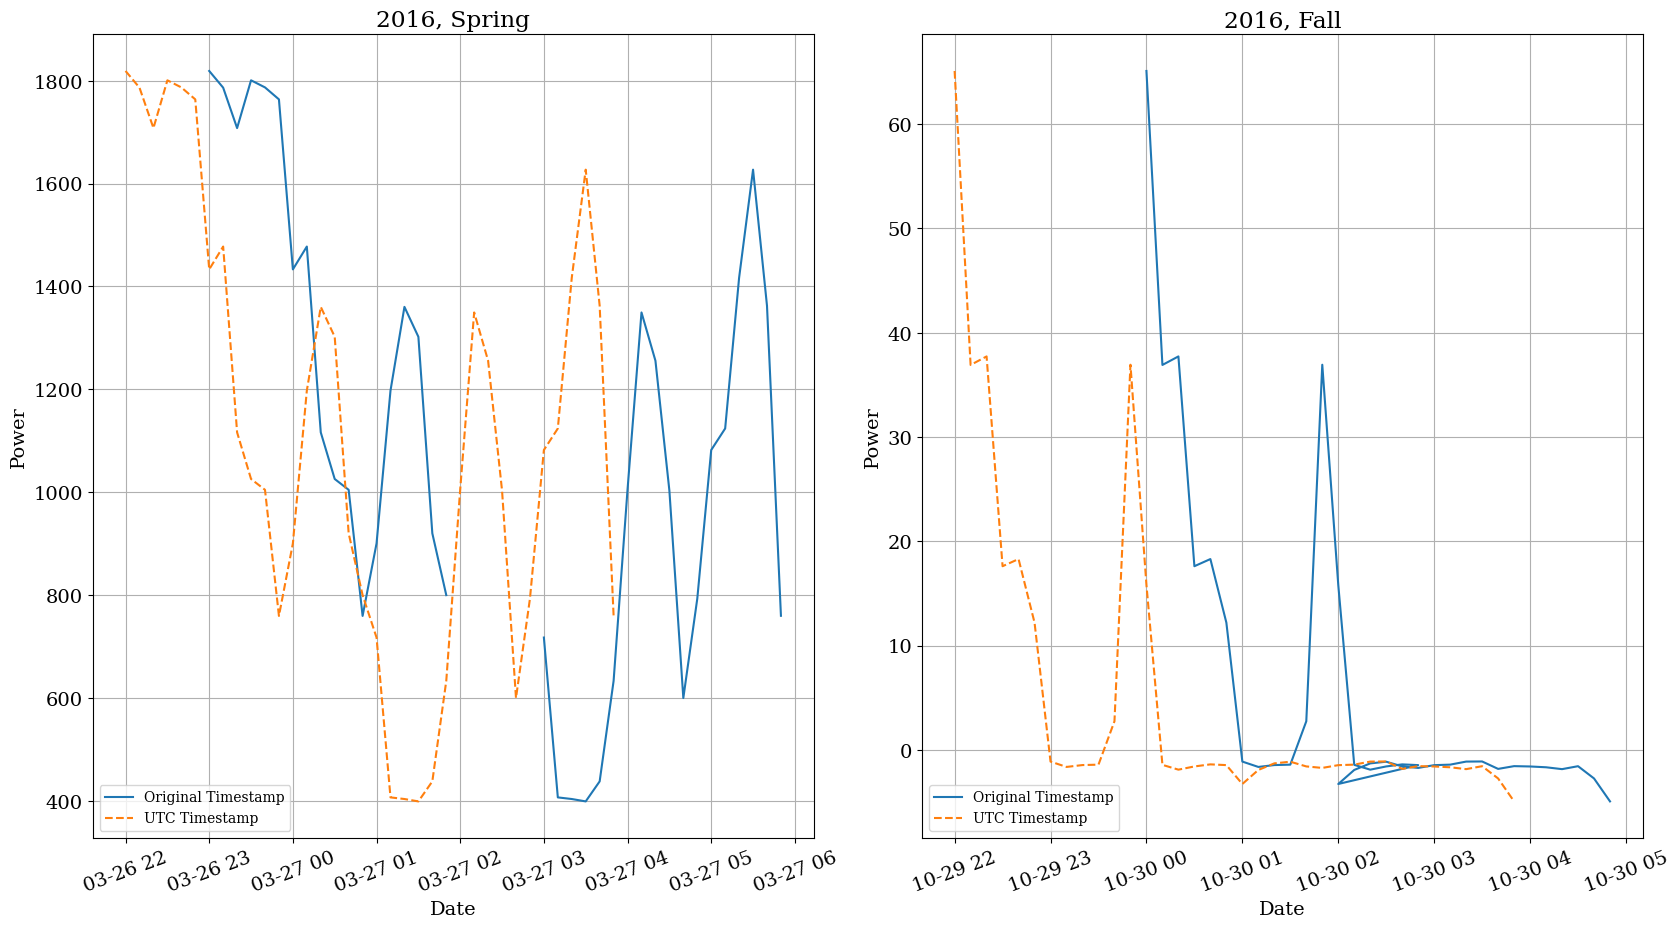

In [20]:
qa.daylight_savings_plot(
    df=scada_df_tz,
    local_tz="Europe/Paris",
    id_col="Turbine",
    time_col="Timestamp",
    power_col="Power (kW)",
    freq="10min",
    hour_window=3  # default value
)